In [1]:
# Process hmmsearch results
# Jackson M. Tsuji, ILTS / UWaterloo, 2022

In [2]:
import pandas as pd
from plotnine import *

In [3]:
# Filter based on BLASTP hits to the L227-S17 and L227_5c strains
blastp_results = pd.read_csv('pscA_fmoA_blastp.tsv', sep='\t')

blastp_results_filtered = blastp_results[(blastp_results['pident'] > 90) & (blastp_results['evalue'] < 1e-10)][['sample','hmm','sseqid']]\
  .drop_duplicates()\
  .rename(columns={'sseqid':'query'})

blastp_results_filtered.head()

,sample,hmm,query
3,Sep2016_L626_11m,fmoA_Chx,HISEQ09_395_CBDRCANXX_1_2205_4774_32844_1_132_+
6,Sep2016_L626_11m,fmoA_Chx,HISEQ09_395_CBDRCANXX_1_1313_13175_43582_1_132_+
206,Jun2016_L304_06m,pscA_Chx,HISEQ15_345_CB2H5ANXX_8_2116_3138_42424_1_151_-
207,Jun2016_L304_06m,pscA_Chx,HISEQ15_345_CB2H5ANXX_8_1201_13651_34702_1_151_+
209,Jun2016_L304_06m,pscA_Chx,HISEQ15_345_CB2H5ANXX_8_2311_6812_33444_1_151_+


In [4]:
# Load hmmsearch data and filter
hmmsearch_results = pd.read_csv('hmmsearch.tsv', sep='\t')

hmmsearch_filtered = blastp_results_filtered.merge(hmmsearch_results, on=['sample','query','hmm'], how='left')

hmmsearch_filtered = pd.concat([hmmsearch_filtered, hmmsearch_results[hmmsearch_results['hmm'] == 'rpoB']])

hmmsearch_filtered.head()

,sample,hmm,query,evalue,score,bias
0,Sep2016_L626_11m,fmoA_Chx,HISEQ09_395_CBDRCANXX_1_2205_4774_32844_1_132_+,1.600000e-20,83.8,0.5
1,Sep2016_L626_11m,fmoA_Chx,HISEQ09_395_CBDRCANXX_1_1313_13175_43582_1_132_+,2.600000e-19,79.9,0.8
2,Jun2016_L304_06m,pscA_Chx,HISEQ15_345_CB2H5ANXX_8_2116_3138_42424_1_151_-,1.200000e-25,101.3,2.4
3,Jun2016_L304_06m,pscA_Chx,HISEQ15_345_CB2H5ANXX_8_1201_13651_34702_1_151_+,2.400000e-24,97.0,0.0
4,Jun2016_L304_06m,pscA_Chx,HISEQ15_345_CB2H5ANXX_8_2311_6812_33444_1_151_+,2.700000e-25,100.2,2.9


In [5]:
# Load HMM lengths
hmm_lengths = pd.read_csv('hmm_lengths.tsv', sep='\t')
hmm_lengths.head()

,hmm,length
0,fmoA_Chx,373
1,pscA_Chx,596
2,rpoB,2842


In [6]:
# Sumamrize counts by sample/HMM
results_summary = hmmsearch_filtered[['sample','hmm','query']]\
  .groupby(['sample','hmm']).count()\
  .reset_index()\
  .pivot(index='sample', columns='hmm', values='query')\
  .reset_index()\
  .fillna(0)

results_summary['Lake'] = results_summary['sample'].str.split('_', expand=True)[1]

# Filter out L111
results_summary = results_summary[results_summary['Lake'] != 'L111']

# Filter out singletons
results_summary = results_summary.set_index(['sample','Lake'])\
  .replace(1,0)\
  .reset_index()

results_summary.head()

hmm,sample,Lake,fmoA_Chx,pscA_Chx,rpoB
0,Jul2014_L227_06m,L227,0.0,0.0,33526.0
1,Jul2014_L227_08m,L227,0.0,0.0,19826.0
2,Jul2014_L442_13m,L442,0.0,0.0,27495.0
3,Jul2018_L221_05m,L221,16.0,26.0,43046.0
4,Jul2018_L239_20m,L239,0.0,0.0,45161.0


In [7]:
results_summary.to_csv('counts-per-sample-blast-filtered.tsv', sep='\t', index=False)

In [8]:
# Take a quick look at positive pscA/fmoA counts - the only somewhat sketchy one is L227, which we already comment on in the paper.
results_summary[(results_summary['pscA_Chx'] > 0) | results_summary['fmoA_Chx'] > 0]

hmm,sample,Lake,fmoA_Chx,pscA_Chx,rpoB
3,Jul2018_L221_05m,L221,16.0,26.0,43046.0
5,Jul2018_L304_06m,L304,17.0,13.0,56888.0
9,Jun2016_L221_05m,L221,158.0,228.0,61746.0
17,Jun2016_L304_06m,L304,8.0,15.0,55578.0
23,Sep2016_L222_05m,L222,4.0,8.0,65363.0
27,Sep2016_L227_08m,L227,2.0,0.0,48591.0
36,Sep2016_L626_11m,L626,2.0,0.0,33461.0
40,Sep2017_L227_06m,L227,2.0,2.0,96180.0
42,Sep2017_L227_10m,L227,0.0,2.0,43729.0


In [9]:
# Normalize
results_norm = results_summary.copy(deep=True)

for index,row in hmm_lengths.iterrows():
    hmm,length = row
    #print(hmm)
    results_norm[hmm] = results_norm[hmm] / length

# Do the last step (normalization to rpoB) semi-manually
results_norm['pscA / rpoB (%)'] = results_norm['pscA_Chx'] / results_norm['rpoB'] * 100
results_norm['fmoA / rpoB (%)'] = results_norm['fmoA_Chx'] / results_norm['rpoB'] * 100

results_norm.head()

hmm,sample,Lake,fmoA_Chx,pscA_Chx,rpoB,pscA / rpoB (%),fmoA / rpoB (%)
0,Jul2014_L227_06m,L227,0.000000,0.000000,11.796622,0.000000,0.000000
1,Jul2014_L227_08m,L227,0.000000,0.000000,6.976073,0.000000,0.000000
2,Jul2014_L442_13m,L442,0.000000,0.000000,9.674525,0.000000,0.000000
3,Jul2018_L221_05m,L221,0.042895,0.043624,15.146376,0.288017,0.283206
4,Jul2018_L239_20m,L239,0.000000,0.000000,15.890570,0.000000,0.000000


In [11]:
results_norm.drop(columns=['pscA / rpoB (%)','fmoA / rpoB (%)'])\
  .to_csv('counts-per-sample-blast-filtered-length-normalized.tsv', sep='\t', index=False)
results_norm.drop(columns=['fmoA_Chx','pscA_Chx','rpoB'])\
  .to_csv('percent-per-sample-blast-filtered-length-normalized.tsv', sep='\t', index=False)

In [12]:
# Prep for plotting - find max. values for each lake
lake_metadata = pd.DataFrame({'Lake': ['L221','L304','L222','L227','L224','L373','L442','L626','L239'],
                             'seasonally_anoxic': [True,True,True,True,True,True,True,True,False],
                             'plotting_id': ['221','304','222','227','224','373','442','626','239 (oxic)']})

norm_max = results_norm[['Lake','pscA / rpoB (%)','fmoA / rpoB (%)']]\
  .groupby(['Lake']).agg('max')\
  .reset_index()\
  .merge(lake_metadata, on='Lake', how='left')\
  .sort_values(by=['pscA / rpoB (%)','seasonally_anoxic'], ascending=True)

norm_max['plotting_id'] = pd.Categorical(norm_max['plotting_id'], categories=norm_max['plotting_id'], ordered=True)

norm_max

,Lake,pscA / rpoB (%),fmoA / rpoB (%),seasonally_anoxic,plotting_id
4,L239,0.000000,0.000000,False,239 (oxic)
2,L224,0.000000,0.000000,True,224
6,L373,0.000000,0.000000,True,373
7,L442,0.000000,0.000000,True,442
8,L626,0.000000,0.045541,True,626
3,L227,0.021809,0.031361,True,227
1,L222,0.058363,0.046628,True,222
5,L304,0.128696,0.227690,True,304
0,L221,1.760775,1.949681,True,221


In [13]:
norm_max.drop(columns=['seasonally_anoxic','plotting_id'])\
  .to_csv('percent-per-lake-blast-filtered-length-normalized-max.tsv', sep='\t', index=False)

/opt/homebrew/Caskroom/miniforge/base/envs/jupyterlab/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10


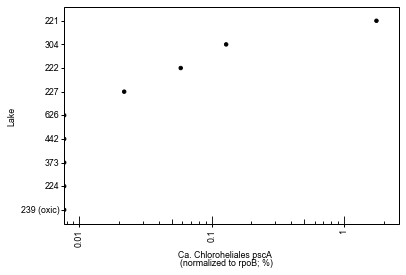

<ggplot: (400604151)>

In [14]:
chx_max_sum_plot = (ggplot(norm_max, aes(y='plotting_id',x='pscA / rpoB (%)'))
                + geom_point()
                + theme_bw()
                + theme(text=element_text(family='Arial', colour='black'),
                        panel_grid=element_blank(),
                        axis_text_x=element_text(angle=90),
                        panel_border=element_rect(colour='black'),
                        axis_ticks_major=element_line(colour='black'),
                        axis_title=element_text(size=8.8))
                + scale_x_log10(limits=[0.01,2])
                + annotation_logticks(sides='b')
                + ylab('Lake')
                + xlab('Ca. Chloroheliales pscA \n(normalized to rpoB; %)'))

chx_max_sum_plot

In [15]:
chx_max_sum_plot.save('pscA_abundances.pdf', width=30, height=65, units='mm')

/opt/homebrew/Caskroom/miniforge/base/envs/jupyterlab/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 30.000000000000004 x 65.00000000000001 mm image.
/opt/homebrew/Caskroom/miniforge/base/envs/jupyterlab/lib/python3.10/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: pscA_abundances_vs4b-print.pdf
/opt/homebrew/Caskroom/miniforge/base/envs/jupyterlab/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
